# Initializing

#### I1) Add the path containing the folder dynet_toolbox

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../') # Here insert path to the directory containing pydynet 

from pydynet import dynet_sim
from pydynet.dynet_con import dynet_ar2pdc, dynet_connplot
from pydynet.dynet_statespace import dynet_SSM_KF, dynet_SSM_STOK
from pydynet.utilities import auc_roc

# Simulation

#### S1) Simulate surrogate data with default network settings

In [6]:
sim = dynet_sim.DynetSim(n = 10, srate=200, duration = 2, order = 5, sparsity = .6, nstates = 3, ntrials = 400, snr_db = 5, lmix = 0 )
sim.simulate()
print(sim)

>> DynetSim:  
 -n:		10 
 -srate:	200 
 -delay:	5 
 -popt:		6 
 -time:		(400,) 
 -frange:	(100,) 
 -sparsity:	0.6 
 -nstates:	3 
 -trials:	400 
 -SC:		(10, 10) 
 -FC:		(10, 10) 
 -AR:		(10, 10, 6, 400) 
 -Y:		(400, 10, 400) 
 -E:		(400, 10, 400) 
 -CT:		(400, 400) 
 -R:		(10, 10) 
 -scaling:	1 
 -regimes:	3 
 -DM:		(10, 10) 
 -LMx:		(10, 10) 
 -summary:	(84, 9) 
 -noise:	(400, 10, 400) 
<<


In [7]:
"""
# TO COMPARE WITH MATLAB
import scipy.io as sio
sim_matlab = sio.loadmat('sim_debug.mat')
sim.AR = sim_matlab['AR']
sim.CT = sim_matlab['CT']
sim.E = sim_matlab['E']
sim.FC = sim_matlab['FC']
sim.noise = sim_matlab['noise']
sim.R = sim_matlab['R']
sim.regimes = {i:elem[0]-1 for i,elem in enumerate(sim_matlab['regimes'][0])}
sim.SC = sim_matlab['SC']
sim.Y = sim_matlab['Y']"""

"\n# TO COMPARE WITH MATLAB\nimport scipy.io as sio\nsim_matlab = sio.loadmat('sim_debug.mat')\nsim.AR = sim_matlab['AR']\nsim.CT = sim_matlab['CT']\nsim.E = sim_matlab['E']\nsim.FC = sim_matlab['FC']\nsim.noise = sim_matlab['noise']\nsim.R = sim_matlab['R']\nsim.regimes = {i:elem[0]-1 for i,elem in enumerate(sim_matlab['regimes'][0])}\nsim.SC = sim_matlab['SC']\nsim.Y = sim_matlab['Y']"

#### S2) Review the main properties of the simulated network

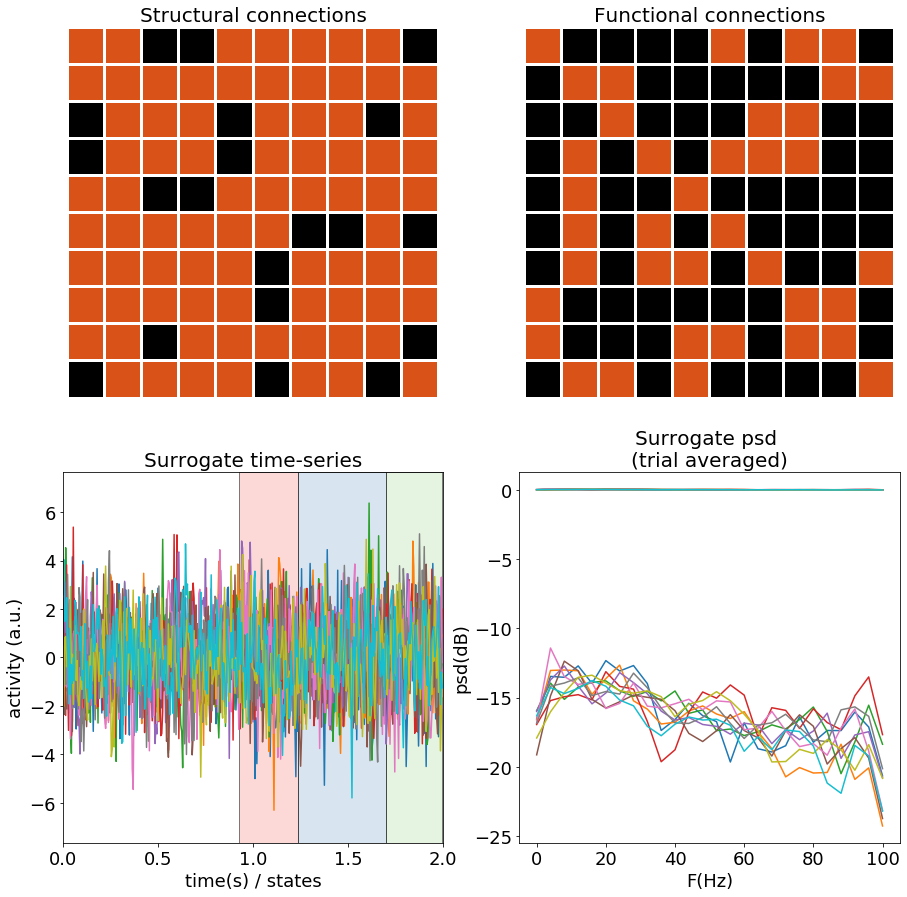

In [8]:
sim.review();

#### S3) Compute and visualize the ground truch PDC obtained directly from the true tvMVAR data-generating process (here squared PDC, column norm)

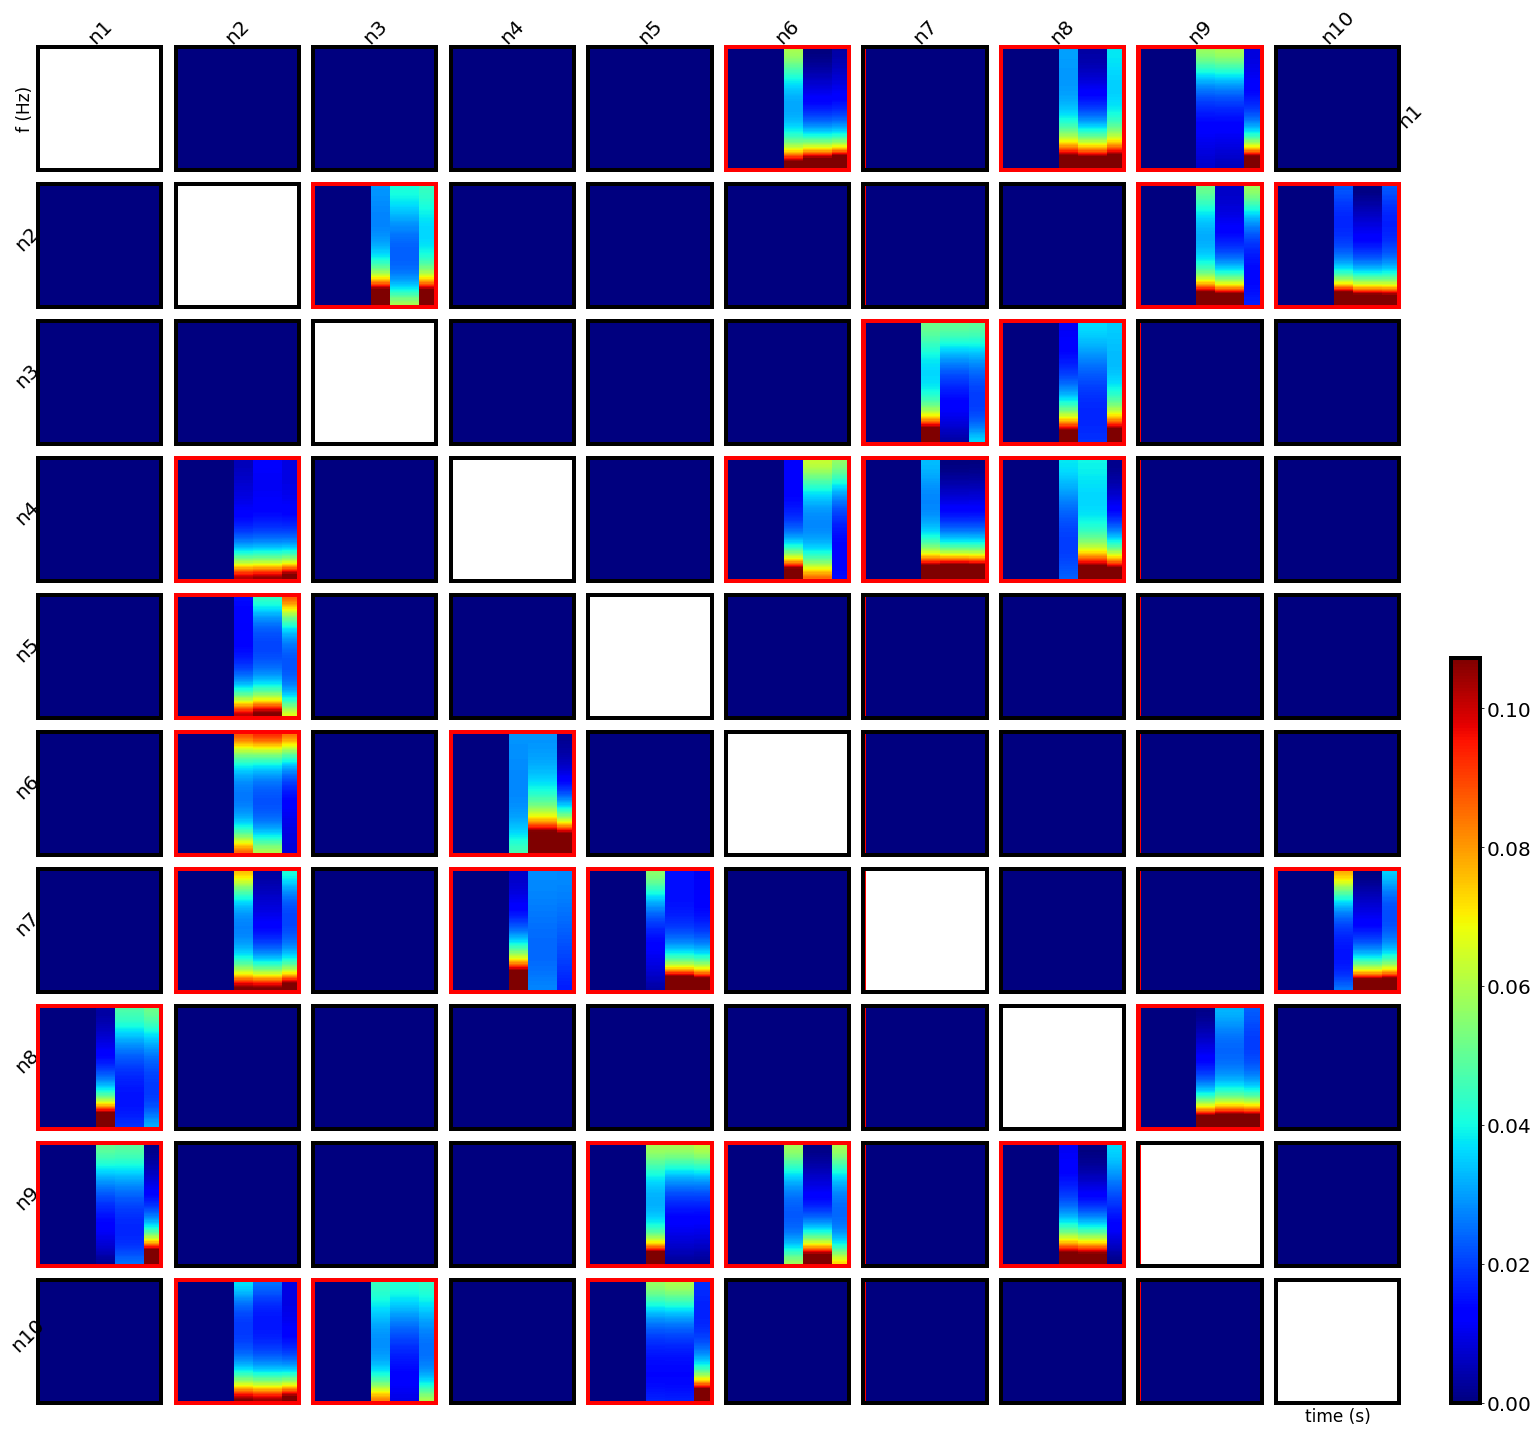

In [9]:
gt_PDC = dynet_ar2pdc(sim,sim.srate,sim.frange, measure='sPDC',univ = 0, flow = 1, PSD = 1)
dynet_connplot(gt_PDC,sim.time,sim.frange, SC = sim.FC, univ = 1)

## Adaptive filtering

#### AF1) Apply the general Linear Kalman Filter (canonical c=0.02) & compute sPDC

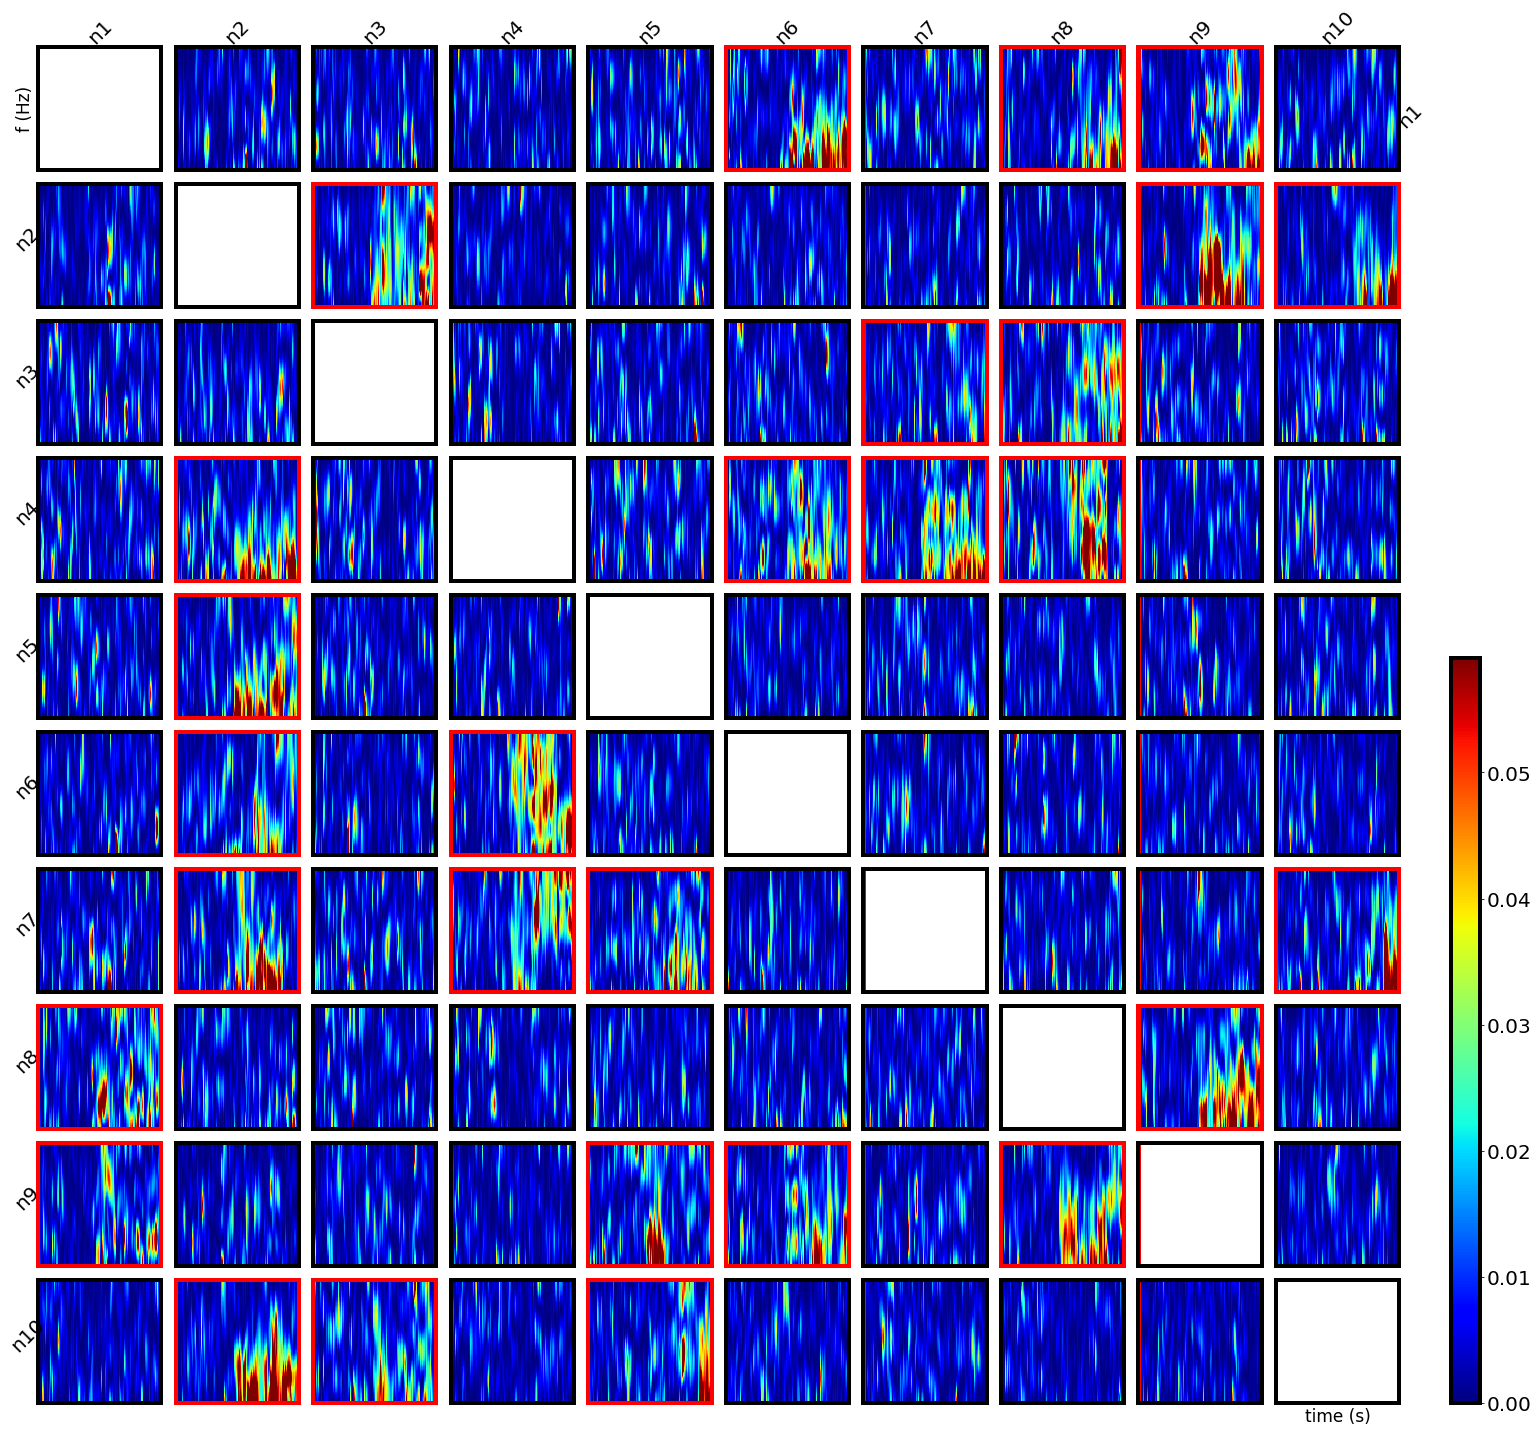

In [10]:
KF = dynet_SSM_KF(Y = sim.Y, p = sim.popt,uc = 0.02)
kf_PDC = dynet_ar2pdc(KF,sim.srate,sim.frange, measure='sPDC',univ = 0, flow = 1, PSD = 1)
dynet_connplot(kf_PDC,sim.time,sim.frange, SC = sim.FC, univ = 1)

#### AF2) Apply the STOK filter and compute sPDC

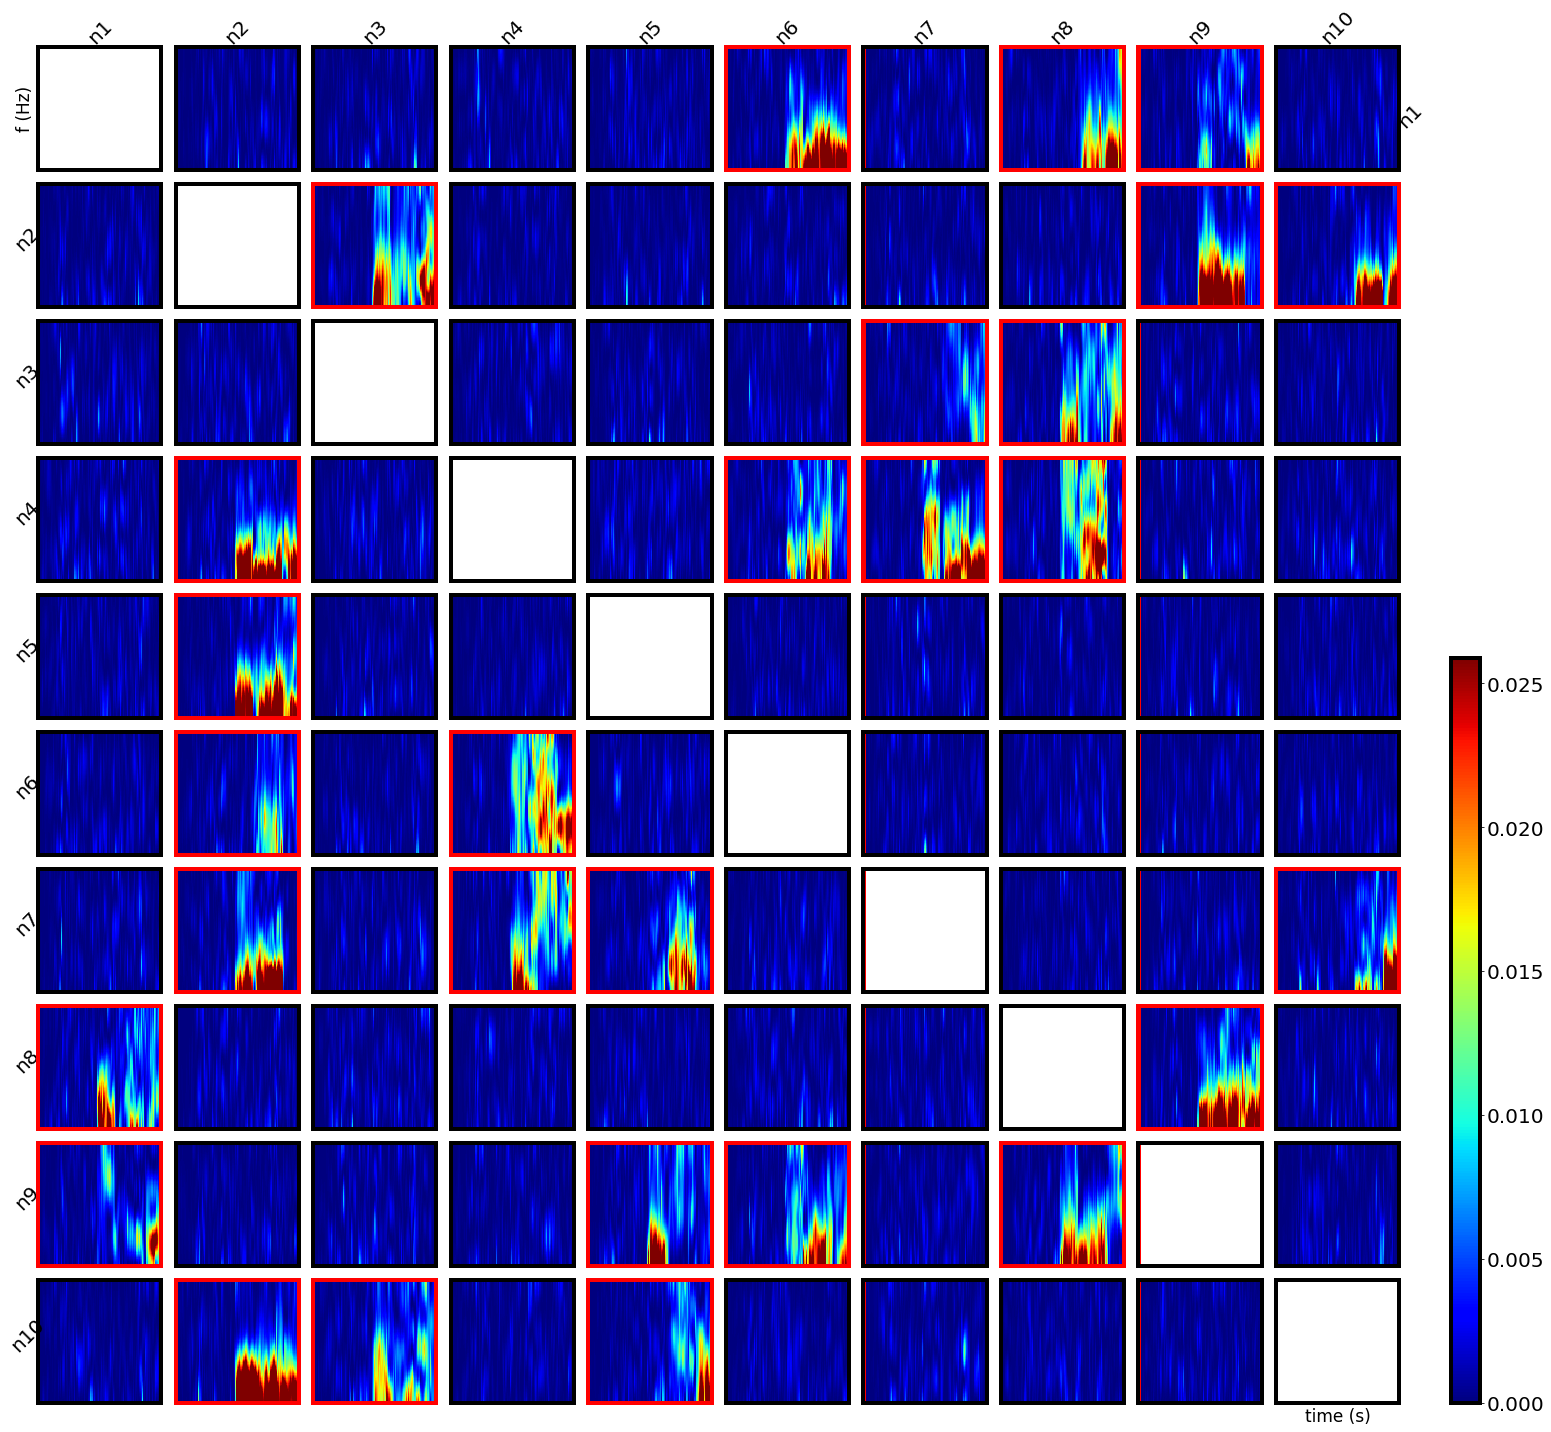

In [11]:
SK = dynet_SSM_STOK(Y = sim.Y, p = sim.popt,ff = .99)
sk_PDC = dynet_ar2pdc(SK,sim.srate,sim.frange, measure='sPDC',univ = 0, flow = 1, PSD = 1)
dynet_connplot(sk_PDC,sim.time,sim.frange, SC = sim.FC, univ = 1)

## Comparison

#### C1) Compare the two algorithms with ROC analysis

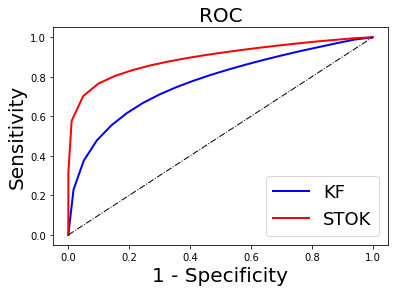

In [12]:
n_crit = 20
spec_kf,sens_kf,auc_kf = auc_roc(gt_PDC,kf_PDC,n_crit)
spec_sk,sens_sk,auc_sk = auc_roc(gt_PDC,sk_PDC,n_crit)

plt.plot(1-spec_kf,sens_kf,'-b',linewidth=2,label='KF')
plt.plot(1-spec_sk,sens_sk,'-r',linewidth=2, label='STOK')
plt.plot(np.linspace(0,1),np.linspace(0,1),'-.k',linewidth=1)
plt.xlabel('1 - Specificity',fontsize=20)
plt.ylabel('Sensitivity',fontsize=20)
plt.title('ROC',fontsize=20)
plt.legend(loc='best',fontsize=18);